 Most significant differences:
* Each user must create an account and find their token
* getting at Table metadata is different and not as informative
* running a job and getting the table is a different command
* ADQL shapes must have a first entry of 'ICRS'
* Default "units" in table are definition and units, we have to manually fix (I've written a function)
* We wont have access to the PanSTARRS photometry table for the final exercise in the JOIN section.

Create account: https://gaia.aip.de/accounts/signup/
Verify email with confirmation email
Your Name --> API token

# Episode 4: Plotting and pandas

Questions
- How do effciently explore our data and identify appropriate !lters to produce a clean sample (in this case of GD-1 stars)? 

Objectives
- Use a Boolean Pandas Series to select rows in a DataFrame.
- Save multiple DataFrame s in an HDF5 file.

- In the previous episode, we wrote a query to select stars from the region of the sky where we expect GD-1 to be, and saved the results in a FITS and HDF5 file. 

- Now we will read that data back in and implement the next step in the analysis, identifying stars with the proper motion we expect for GD-1.



OUTLINE
1. We will put those results into a Pandas DataFrame , which we will use to select stars near the centerline of GD-1.
2. Plotting the proper motion of those stars, we will identify a region of proper motion for stars that are likely to be in GD-1.
3. Finally, we will select and plot the stars whose proper motion is in that region.

- Pandas
    - great for exploring
    - `describe()` function gives summary statistics

In [182]:
results_df.describe()

,source_id,ra,dec,pmra,pmdec,parallax,phi1,phi2,pm_phi1,pm_phi2
count,1.403390e+05,140339.000000,140339.000000,140339.000000,140339.000000,140339.000000,140339.000000,140339.000000,140339.000000,140339.000000
mean,6.792399e+17,143.823122,26.780285,-2.484403,-6.100776,0.179492,-50.091158,-1.803301,-0.868962,1.409207
std,3.792177e+16,3.697850,3.052592,5.913939,7.202047,0.759590,2.892344,3.444398,6.657714,6.518616
min,6.214900e+17,135.425699,19.286617,-106.755000,-138.065000,-15.287600,-54.999989,-8.029159,-115.276079,-161.150259
25%,6.443517e+17,140.967966,24.592490,-5.039000,-8.341500,-0.036000,-52.602952,-4.750426,-2.948590,-1.107203
50%,6.888060e+17,143.734409,26.746261,-1.835000,-4.690000,0.362700,-50.147362,-1.671502,0.585015,1.987239
75%,6.976579e+17,146.607350,28.990500,0.453000,-1.938000,0.657600,-47.593279,1.160514,3.002020,4.628968
max,7.974418e+17,152.777393,34.285481,104.320000,20.981000,1.000000,-44.999985,4.014609,39.802663,79.275024



### Excercise (10 min)

QUESTIONS
- Do the values make sense based on what you know about the context?
- Do you see any values that seem problematic, or evidence of other data issues?

SOLUTION
- The most noticeable issue is that some of the **parallax values are negative**, which seems non-physical.

- Gaia database can arise from a number of causes like source confusion (high negative values) and the parallax zero point with systematic errors (low negative values). 

- Fortunately, we do not use the parallax measurements in the analysis (one of the reasons we used constant distance for re#ex correction).

## Plot proper motion

- look at original **figure 1**
    - proper motion as a scatter plot

- Why do we **expect motion** in the direction of phi2 to be near 0?
- form a **cluster** at a non-zero value.
- **select** stars that are more likely to be in GD-1.

Now let's create a scatter plot of proper motion, in the GD-1 frame, for the stars in results_df .

Text(0, 0.5, 'Proper motion phi2 (mas/yr GD1 frame)')

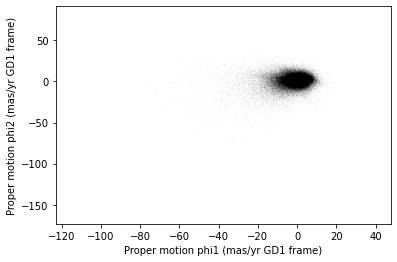

In [183]:
x = results_df['pm_phi1'] 
y = results_df['pm_phi2']
plt.plot(x, y, 'ko', markersize=0.1, alpha=0.1)
    
plt.xlabel('Proper motion phi1 (mas/yr GD1 frame)')
plt.ylabel('Proper motion phi2 (mas/yr GD1 frame)')

Most of the proper motions are near the origin
- use xlim and ylim to zoom

(-10.0, 10.0)

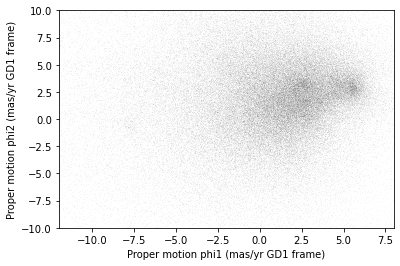

In [184]:
x = results_df['pm_phi1']
y = results_df['pm_phi2']
plt.plot(x, y, 'ko', markersize=0.1, alpha=0.1)
    
plt.xlabel('Proper motion phi1 (mas/yr GD1 frame)')
plt.ylabel('Proper motion phi2 (mas/yr GD1 frame)')

plt.xlim(-12, 8)
plt.ylim(-10, 10)

- overdense region near (-7.5, 0)

## Selecting the centerline

LOOK AT FIGURE 1
- less than 1 degree from the line `\phi_2 = 0`
- to select them we will use a "Boolean Mask"

In [185]:
phi2 = results_df['phi2']
type(phi2)

pandas.core.series.Series

- use comparison operator `>`

In [186]:
phi2_min = -1.0 * u.degree
phi2_max = 1.0 * u.degree

mask = (phi2 > phi2_min)
type(mask)

pandas.core.series.Series

- the result is a `series` which Pandas uses to represent a column


In [187]:
mask.head()

0    False
1    False
2    False
3    False
4    False
Name: phi2, dtype: bool

- use the `&` operator to create the "logical and"
- result is true where both boolean series are true 

In [188]:
mask = (phi2 > phi2_min) & (phi2 < phi2_max)

- Python’s logical operators ( and , or , and not ) do not work with NumPy or Pandas. Both libraries use the bitwise operators ( & , | , and ~ ) to do elementwise logical operations (explanation here (https://stackover#ow.com/questions/21415661/logical-operators-for-boolean-indexing-in-pandas)

In [189]:
mask.sum()

25084

- Boolean Series is sometimes called a “mask”

    HERE WE mask out some of the rows in a DataFrame and select the rest

In [190]:
centerline_df = results_df[mask]
type(centerline_df)

pandas.core.frame.DataFrame

- true values in the mask are stars close to the centerline of GD-1

In [191]:
len(centerline_df)

25084

- what fraction of the rows have we selected?

In [192]:
len(centerline_df) / len(results_df)

0.1787386257562046

- about 18% or 25000

## Plotting proper motion

second time we are plotting proper motion
- instead of copy and paste... lets write a function

In [193]:
def plot_proper_motion(df):
    """Plot proper motion.
    
    df: DataFrame with `pm_phi1` and `pm_phi2`
    """
    x = df['pm_phi1']
    y = df['pm_phi2']
    plt.plot(x, y, 'ko', markersize=0.3, alpha=0.3)

    plt.xlabel('Proper motion phi1 (mas/yr)')
    plt.ylabel('Proper motion phi2 (mas/yr)')

    plt.xlim(-12, 8)
    plt.ylim(-10, 10)

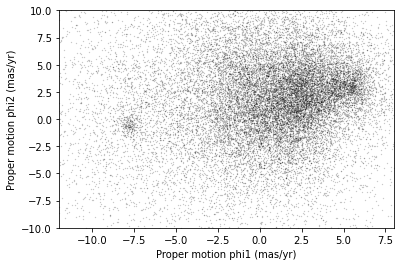

In [194]:
plot_proper_motion(centerline_df)

- now we really see cluster
- less dense... because we started with a smaller section... about 10 times smaller


## Filtering based on proper motion

- "overdense" region of proper motion

In [195]:
pm1_min = -8.9
pm1_max = -6.9
pm2_min = -2.2
pm2_max =  1.0

- use our `make_rectangle` function

In [196]:
pm1_rect, pm2_rect = make_rectangle(
    pm1_min, pm1_max, pm2_min, pm2_max)

- draw a rectangle with coordinates

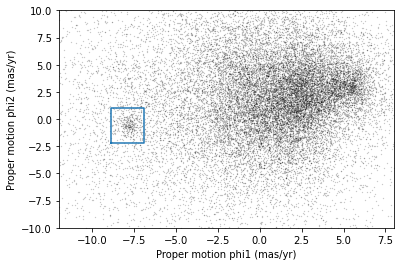

In [197]:
plot_proper_motion(centerline_df)
plt.plot(pm1_rect, pm2_rect, '-')

- use these proper motion bounds to select rows from `results_df`
- write a function
    - use Pandas operators to create a mask

In [198]:
def between(series, low, high):
    """Check whether values are between `low` and `high`."""
    return (series > low) & (series < high)

In [199]:
pm1 = results_df['pm_phi1']
pm2 = results_df['pm_phi2']

pm_mask = (between(pm1, pm1_min, pm1_max) & 
           between(pm2, pm2_min, pm2_max))

In [200]:
pm_mask.sum()

1049

In [201]:
selected_df = results_df[pm_mask]
len(selected_df)

1049

- these are the stars likly to be in GD-1
- now plot, with coordinate axis

Text(0, 0.5, 'phi2 (degree GD1)')

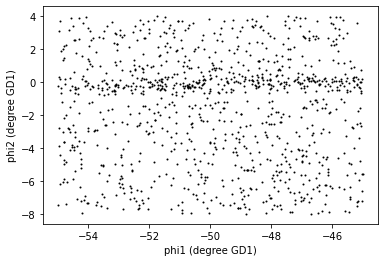

In [202]:
x = selected_df['phi1']
y = selected_df['phi2']
plt.plot(x, y, 'ko', markersize=1, alpha=1)

plt.xlabel('phi1 (degree GD1)')
plt.ylabel('phi2 (degree GD1)')

**WE SEE THE TIDLE STREAM!**

- 2 new matplotlib commands
    - `axis` is used to make x and y units equal
    - `title` with `fontsize` medium.
        - large is default

(-55.49280321308642,
 -44.503699550732435,
 -8.606246809550676,
 4.601299340485905)

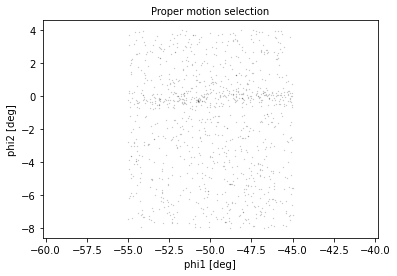

In [203]:
x = selected_df['phi1']
y = selected_df['phi2']

plt.plot(x, y, 'ko', markersize=0.3, alpha=0.3)

plt.xlabel('phi1 [deg]')
plt.ylabel('phi2 [deg]')
plt.title('Proper motion selection', fontsize='medium')

plt.axis('equal')

- put code into a function `plot_pm_selection`
    - put the code, we wrote to make one of the panel figures, into a function
        - we will in future episodes to recreate this entire plot with a **single line of code.**

In [204]:
def plot_pm_selection(df):
    """Plot in GD-1 spatial coordinates the location of the stars
    selected by proper motion
    """
    x = df['phi1']
    y = df['phi2']

    plt.plot(x, y, 'ko', markersize=0.3, alpha=0.3)

    plt.xlabel('phi1 [deg]')
    plt.ylabel('phi2 [deg]')
    plt.title('Proper motion selection', fontsize='medium')

    plt.axis('equal')

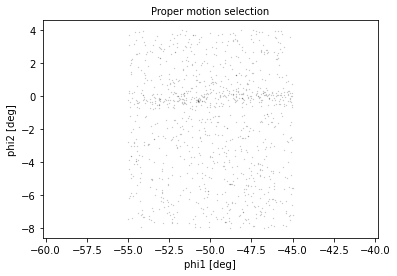

In [205]:
plot_pm_selection(selected_df)

## Saving the DataFrame

- save the data
    - We have already started a results file called `gd1_data.hdf`
- HDF5 is binary and fast and a cross-language standard
    - needs a "key" to identify the dataset
- use the same name for "key" as the `DataFrame`
    - `selected_df`

In [206]:
filename = 'gd1_data.hdf'

selected_df.to_hdf(filename, 'selected_df')

### Exercise (5 min)

We are going to need `centerline_df` later as well. Write a line of code to add it as a second Dataset in the HDF5.

**Hint!**: Since the file already exists, you should not use `mode='w'`!

In [207]:
centerline_df.to_hdf(filename, 'centerline_df')

- use `getsize` to check
    - getsize returns a value in bytes

In [208]:
from os.path import getsize

MB = 1024 * 1024
getsize(filename) / MB

13.992530822753906

- if you forget the names of Datasets in file, read back like this

In [209]:
with pd.HDFStore(filename) as hdf:
    print(hdf.keys())

['/centerline_df', '/results_df', '/selected_df']


? Azalee's original `results_df` file also had `'/candidate_df'`

## Summary


In this episode, we re-loaded the transformed Gaia data we saved from a previous query.

Then we prototyped the selection process from the Price-Whelan and Bonaca paper locally using data that we had already downloaded.:

- We selected stars near the **centerline** of GD-1 and made a scatter plot of their proper motion. 

- We identifed a **region of proper motion** that contains stars likely to be in GD-1.

- We used a Boolean Series as a **mask** to select stars whose proper motion is in that region.

So far, we have used data from a relatively small region of the sky so that our local dataset was not too big. In the next lesson, we will write a query that selects stars based on the proper motion limits we identi!ed in this lesson, which will allow us to explore a larger region.